This notebook shows the effect of Rayleigh scattering on the Cherenkov signal of an EAS. First let's create a shower simulation. Let's define a grid of 100 by 100 detectors centered around the shower footprint. To see the effect of a curved atmosphere, let's give the shower a zenith angle of 80 degrees. Due to the heavy wavelength dependence of the Rayleigh scattering cross section, I'm only considering a narrow wavelength bin from 300 nm to 315 nm, and using the cross section of the median wavelength. In the future, I will attenuate many small  wavelength bins with their appropriate Rayleigh cross section, then aggregate the signal. At this point I'm just trying to get the code vectorized.

In [1]:
from simulation import *
import matplotlib.pyplot as plt
%matplotlib inline

theta = np.radians(60)
phi = np.radians(45)

x = np.linspace(-1000,1000,100)
xx, yy = np.meshgrid(x,x)
counters = np.empty([xx.size,3])
counters[:,0] = xx.flatten()
counters[:,1] = yy.flatten()
counters[:,2] = np.zeros(xx.size)

sim = ShowerSimulation()
sim.add(DownwardAxis(theta,phi))
sim.add(GHShower(666.,6e7,0.,70.))
sim.add(Counters(counters, 1))
sim.add(Yield(300,450))
sim.run(curved = False)

Now let's plot the signal of this shower without attenuation.

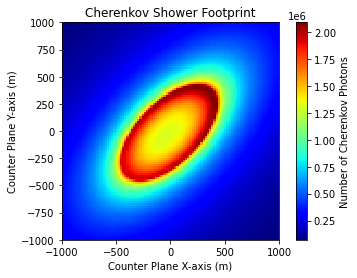

In [2]:
fig = plt.figure()
h2d = plt.hist2d(counters[:,0],counters[:,1],weights=sim.get_photon_sum(),bins=100, cmap=plt.cm.jet)
plt.title('Cherenkov Shower Footprint')
plt.xlabel('Counter Plane X-axis (m)')
plt.ylabel('Counter Plane Y-axis (m)')
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(label = 'Number of Cherenkov Photons')

To show the cross section calculation, I'll use the attenuation object's Rayleigh cross section method with a number of wavelengths. It takes 2 arguments, the first is the altitude (since it directly depends on the number density of scatterers) and the second is the wavelength of the scattered light in nanometers. The algorithm neglects the so called 'King correction factor' for depolarization.

Text(0.5, 1.0, 'Rayleigh CS vs Wavelength')

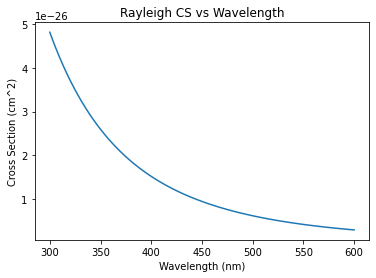

In [3]:
ls = np.linspace(300,600,100)
att = sim.attenuations[0,0]
plt.figure()
plt.plot(ls,att.rayleigh_cs(0.,ls))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Cross Section (cm^2)')
plt.title('Rayleigh CS vs Wavelength')

Now I'll plot the fraction of a vertically travelling beam which is lost along each altitude interval. It is calculated using the Beer-Lambert law. Each step's fractional loss is:
$$
\frac{I}{I_0} = e^{\sigma_R N dh}
$$
Where $\sigma_R$ is the local Rayleigh cross section, $N$ is the local number density of air molecules, and $dh$ is the vertical distance associated with these values. In this case the cross section is that of the median wavelength in the simulation's wavelength interval.

The total fraction of light passed is the product of the fractions passed at each axis step. This allows us to turn the product into a sum after taking the log.
$$
\frac{I_d}{I_0} = \prod_{t}^{d} e^{\sigma_R N_t \frac{dh}{\cos{\theta_t}}} = e^{\sum_{t}^{d} \sigma_R N_t \frac{dh}{\cos{\theta_t}}}
$$
$$
\log{\frac{I_d}{I_0}} = \sum_{t}^{d} \sigma_R N_t \frac{dh}{\cos{\theta_t}}
$$

Text(0.5, 1.0, 'Fraction Passed in a vertical beam')

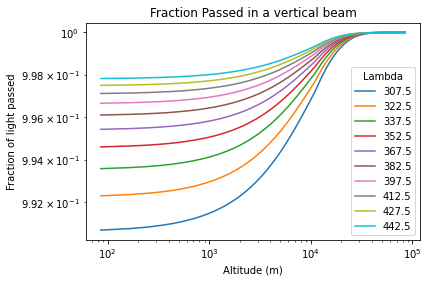

In [4]:
plt.figure()
for i, vlf in enumerate(att.vertical_log_fraction()):
    l = att.yield_array[i].l_mid
    plt.plot(att.axis.h[1:], np.exp(vlf)[1:],label=f"{l}")
plt.ylabel('Fraction of light passed')
plt.xlabel('Altitude (m)')
plt.legend(title='Lambda')
plt.loglog()
plt.title('Fraction Passed in a vertical beam')

Now let's attenuate the signal. This attenuation is the flat-planar atmosphere approximation, meaning the distance $dh$ is calculated by dividing the vertical $dh$ by the cosine of the angle between the photon's path to the counter and vertical. Since the atmosphere is flat, this angle is the same at each altitude.

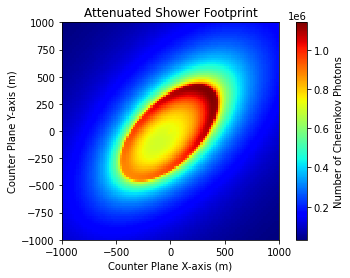

In [5]:
fig = plt.figure()
h2d = plt.hist2d(counters[:,0],counters[:,1],weights=sim.get_attenuated_photon_sum(),bins=100, cmap=plt.cm.jet)
plt.title('Attenuated Shower Footprint')
plt.xlabel('Counter Plane X-axis (m)')
plt.ylabel('Counter Plane Y-axis (m)')
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(label = 'Number of Cherenkov Photons')

Now let's see the effect of having a curved atmosphere. In this case the angle between the photon's path and vertical (i.e. normal to the atmosphere) depends on altitude. This effectively shortens the path length of photons compared with the flat-planar approximation, meaning there is less attenuation.

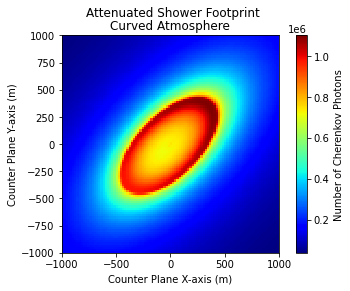

In [6]:
sim.run(curved = True)

fig = plt.figure()
h2d = plt.hist2d(counters[:,0],counters[:,1],weights=sim.get_attenuated_photon_sum(),bins=100, cmap=plt.cm.jet)
plt.suptitle('Attenuated Shower Footprint')
plt.title('Curved Atmosphere')
plt.xlabel('Counter Plane X-axis (m)')
plt.ylabel('Counter Plane Y-axis (m)')
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(label = 'Number of Cherenkov Photons')